In [1]:
import pandas as pd
import numpy as np
import itertools 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import *
import math
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#input local path to CRyPTIC tables
file_path ="../cryptic_data_analysis/data_tables/cryptic-analysis-group"

In [2]:
#load data and make MIC integer
p_data = phenotypes = pd.read_pickle(file_path+"/UKMYC_PHENOTYPES.pkl.gz")
p_data.reset_index(level=1, inplace=True)
p_data.reset_index(level=0, inplace=True)
p_data=p_data.loc[p_data.DRUG.isin(['LEV','MXF'])]
p_data=p_data.loc[p_data['BELONGS_GPI']==True]

#remove isolates iwth no MIC
mic_nan=p_data.loc[p_data['MIC'].isna()].index

p_data=p_data.drop(mic_nan)
p_data=p_data.loc[p_data.PHENOTYPE_QUALITY!='LOW']


#load mutations data
m_data=pd.read_csv(file_path+"/MUTATIONS_GPI.csv.gz")
m_data=m_data.loc[m_data.GENE.isin(['gyrA','gyrB'])]

In [3]:
#merge phenotypes and mutations
data=pd.merge(p_data, m_data, on='UNIQUEID', how='left')
#create gene mutation combo columns
data['geneXmutation']=data['GENE']+" "+data['MUTATION']
data['int_aa']=data.POSITION.astype('Int64')
data['str_aa']=data.int_aa.astype('str')
data['geneXaa']=data['GENE']+" "+data['str_aa']

In [4]:
#samples
drugs_to_test=['LEV', 'MXF']
n_drug=[]
n_r_drug=[]
for i in drugs_to_test:
    n_drug.append(data.loc[data.DRUG==i].UNIQUEID.nunique())
    n_r_drug.append(data.loc[(data.DRUG==i)&(data.BINARY_PHENOTYPE=='R')].UNIQUEID.nunique())
n_df=pd.DataFrame(list(zip(drugs_to_test, n_drug, n_r_drug)), columns=['drug','n_isolates','n_resistant'])
n_df['percentage_resistant']=round(n_df.n_resistant/n_df.n_isolates*100,1)
n_df.to_csv('sample_nos.csv')
n_df

,drug,n_isolates,n_resistant,percentage_resistant
0,LEV,9128,1603,17.6
1,MXF,8138,1324,16.3


In [5]:
#load mutations detected by tests and create gene mutation combo columns
test_data=pd.read_csv('assay_mutations_fq.csv')
test_data['geneXmutation']=test_data['Gene']+" "+test_data['Mutation']
test_data['int_position']=test_data.Region.astype('Int64')
test_data['str_position']=test_data.int_position.astype('str')
geneXaa=[]
geneXn=[]
for index,row in test_data.iterrows():
    if row['aa']==1 and pd.isna(row['Mutation']):
        geneXaa.append(row['Gene']+" "+row['str_position'])
        geneXn.append(np.nan)
    elif row['n']==1 and pd.isna(row['Mutation']):
        geneXn.append(row['Gene']+" "+row['str_position'])
        geneXaa.append(np.nan)
    else:
        geneXaa.append(np.nan)
        geneXn.append(np.nan)
test_data['geneXaa']=geneXaa
test_data['geneXn']=geneXn

In [6]:
def mutations_list_performance(drug_code, test_name, mut_or_region):
    '''takes drug string ('MXF'/'LEV'), name of drug susceptibility test, and test interpretation to use (mut or region),
    returns dataframe of performance of test on the data dataframe'''

    t_data = test_data.loc[(test_data.Test==test_name)&(test_data.Drug==drug_code)]
    
    r_data=data.loc[(data.DRUG==drug_code)&(data.BINARY_PHENOTYPE=='R')]
    s_data=data.loc[(data.DRUG==drug_code)&(data.BINARY_PHENOTYPE=='S')]
    r_samples=r_data.UNIQUEID.nunique()
    s_samples=s_data.UNIQUEID.nunique()
    
    r_mutation_df=pd.DataFrame()
    s_mutation_df=pd.DataFrame()
    r_mutation_df = r_mutation_df.append(r_data.loc[((r_data.geneXmutation.notna())&(r_data.geneXmutation.isin(t_data['geneXmutation'].to_list())))])
    
    s_mutation_df = s_mutation_df.append(s_data.loc[((s_data.geneXmutation.notna())&(s_data.geneXmutation.isin(t_data['geneXmutation'].to_list())))])

    if mut_or_region=='region':
        s_mutation_df = s_mutation_df.append(s_data.loc[(data.IS_NULL!=True)
                                                        &(data.IS_FILTER_PASS!=False)
                                                        &(data.IS_HET!=True)
                                                        &(s_data.POSITION.notna())
                                                        &(-s_data.MUTATION.isin(t_data['Susceptible'].dropna().to_list()))
                                                        &((s_data.geneXaa.isin(t_data['geneXaa'].dropna().to_list())))])
        r_mutation_df = r_mutation_df.append(r_data.loc[(data.IS_NULL!=True)
                                                        &(data.IS_FILTER_PASS!=False)
                                                        &(data.IS_HET!=True)
                                                        &(r_data.POSITION.notna())
                                                        &(-r_data.MUTATION.isin(t_data['Susceptible'].dropna().to_list()))
                                                        &((r_data.geneXaa.isin(t_data['geneXaa'].dropna().to_list())))])            

    r_mutations= r_mutation_df.UNIQUEID.nunique()    
    s_mutations= s_mutation_df.UNIQUEID.nunique()
    sens=r_mutations/r_data.UNIQUEID.nunique()
    sens_lb=(2*r_samples*sens+3.8416-1-1.96*math.sqrt(3.8416-2-(1/r_samples)+4*sens*(r_samples*(1-sens)+1)))/(2*(r_samples+3.8416))
    sens_ub=(2*r_samples*sens+3.8416+1+1.96*math.sqrt(3.8416-2-(1/r_samples)+4*sens*(r_samples*(1-sens)+1)))/(2*(r_samples+3.8416))
    spec=(s_data.UNIQUEID.nunique()-s_mutations)/s_data.UNIQUEID.nunique()
    spec_lb=(2*s_samples*spec+3.8416-1-1.96*math.sqrt(3.8416-2-(1/s_samples)+4*spec*(s_samples*(1-spec)+1)))/(2*(s_samples+3.8416))
    spec_ub=(2*s_samples*spec+3.8416+1+1.96*math.sqrt(3.8416-2-(1/s_samples)+4*spec*(s_samples*(1-spec)+1)))/(2*(s_samples+3.8416))
    df = pd.DataFrame([{'Drug':drug_code,'Name':test_name, 
                       'No_R':r_samples, 'No_S':s_samples,
                       'R_mut':r_mutations,'S_mut':s_mutations,
                       'Sensitivity':sens, 'sens_LB':sens_lb, 'sens_UB':sens_ub, 'Specificity':spec, 
                        'spec_LB':spec_lb, 'spec_UB':spec_ub, 'Mut_or_Reg':mut_or_region}])
    return df

In [7]:
#make dataframe containing performance for all diagnostic tests and who catalogue mutations
results_df = pd.DataFrame()

region_test_data=test_data.loc[test_data.Region.notna()]
mutation_test_data=test_data.loc[test_data.Mutation.notna()]
for i in mutation_test_data.Drug.unique():
    for j in mutation_test_data.loc[mutation_test_data.Drug==i].Test.unique():
        if j == 'WHO 2021 catalogue':
            results_df=results_df.append(mutations_list_performance(i, j, 'cat'))

region_test_data=test_data.loc[test_data.Region.notna()]
for i in region_test_data.Drug.unique():
    for j in region_test_data.loc[region_test_data.Drug==i].Test.unique():
        results_df=results_df.append(mutations_list_performance(i, j, 'region'))
        
for i in mutation_test_data.Drug.unique():
    for j in mutation_test_data.loc[mutation_test_data.Drug==i].Test.unique():
        if j != 'WHO 2021 catalogue':
            results_df=results_df.append(mutations_list_performance(i, j, 'mut'))
results_df.reset_index(drop=True, inplace=True) 
results_df.to_csv('in_silico_diagnostic_test_results.csv')

In [8]:
results_df.loc[results_df.Name=='WHO 2021 catalogue']

,Drug,Name,No_R,No_S,R_mut,S_mut,Sensitivity,sens_LB,sens_UB,Specificity,spec_LB,spec_UB,Mut_or_Reg
0,MXF,WHO 2021 catalogue,1324,6814,1131,410,0.854230,0.833800,0.872610,0.939830,0.933855,0.945309,cat
1,LEV,WHO 2021 catalogue,1603,7525,1332,210,0.830942,0.811483,0.848819,0.972093,0.968053,0.975651,cat


In [9]:
#create dictionary assigning colors to each test

cmap = cm.get_cmap('viridis', len(results_df.Name.unique())-1)  # matplotlib color palette name, n colors
colors=['black']
for i in range(cmap.N):
    rgb = cmap(i)[:3]  # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))
    
test_names=['WHO 2021 catalogue','AID TB FQ/EMB Kit', 'Anyplex II MTB/MDR/XDR',
'Genoscholar FQ+KM-TB II',
'GenoType MTBDRsl Ver 1.0',
'GenoType MTBDRsl Ver 2.0',
'MeltPro MTB/FQ',
'REBA MTB/XDR',
'Xpert MTB/XDR']


colors_dict = {test_names[i]: colors[i] for i in range(len(test_names))}
colors_dict

{'WHO 2021 catalogue': 'black',
 'AID TB FQ/EMB Kit': '#440154',
 'Anyplex II MTB/MDR/XDR': '#46327e',
 'Genoscholar FQ+KM-TB II': '#365c8d',
 'GenoType MTBDRsl Ver 1.0': '#277f8e',
 'GenoType MTBDRsl Ver 2.0': '#1fa187',
 'MeltPro MTB/FQ': '#4ac16d',
 'REBA MTB/XDR': '#a0da39',
 'Xpert MTB/XDR': '#fde725'}

In [10]:
def sort_values(df, column_names, ascending=False, fixed=None):
    '''sorts dataframe based on column, takes dataframe, column. Can pass index to fixed to keep a row in the same position'''
    if fixed is None:
        return df.sort_values(column_names, ascending=ascending)
    idx = df.index.get_indexer(fixed).tolist()
    s_df = df.sort_values(column_names, ascending=ascending).T
    keep_cols = s_df.columns.difference(fixed, sort=False)
    out = s_df[keep_cols]
    for (loc, name) in zip(idx, fixed):
        out.insert(loc, name, s_df[name])
    return out.T

['WHO 2021 catalogue', 'AID TB FQ/EMB Kit', 'AID TB FQ/EMB Kit', 'Anyplex II MTB/MDR/XDR', 'GenoType MTBDRsl Ver 1.0', 'GenoType MTBDRsl Ver 1.0', 'GenoType MTBDRsl Ver 2.0', 'GenoType MTBDRsl Ver 2.0', 'Genoscholar FQ+KM-TB II', 'Genoscholar FQ+KM-TB II', 'MeltPro MTB/FQ', 'REBA MTB/XDR', 'REBA MTB/XDR', 'Xpert MTB/XDR']
['WHO 2021 catalogue', 'AID TB FQ/EMB Kit', 'AID TB FQ/EMB Kit', 'Anyplex II MTB/MDR/XDR', 'GenoType MTBDRsl Ver 1.0', 'GenoType MTBDRsl Ver 1.0', 'GenoType MTBDRsl Ver 2.0', 'GenoType MTBDRsl Ver 2.0', 'Genoscholar FQ+KM-TB II', 'Genoscholar FQ+KM-TB II', 'MeltPro MTB/FQ', 'REBA MTB/XDR', 'REBA MTB/XDR', 'Xpert MTB/XDR']


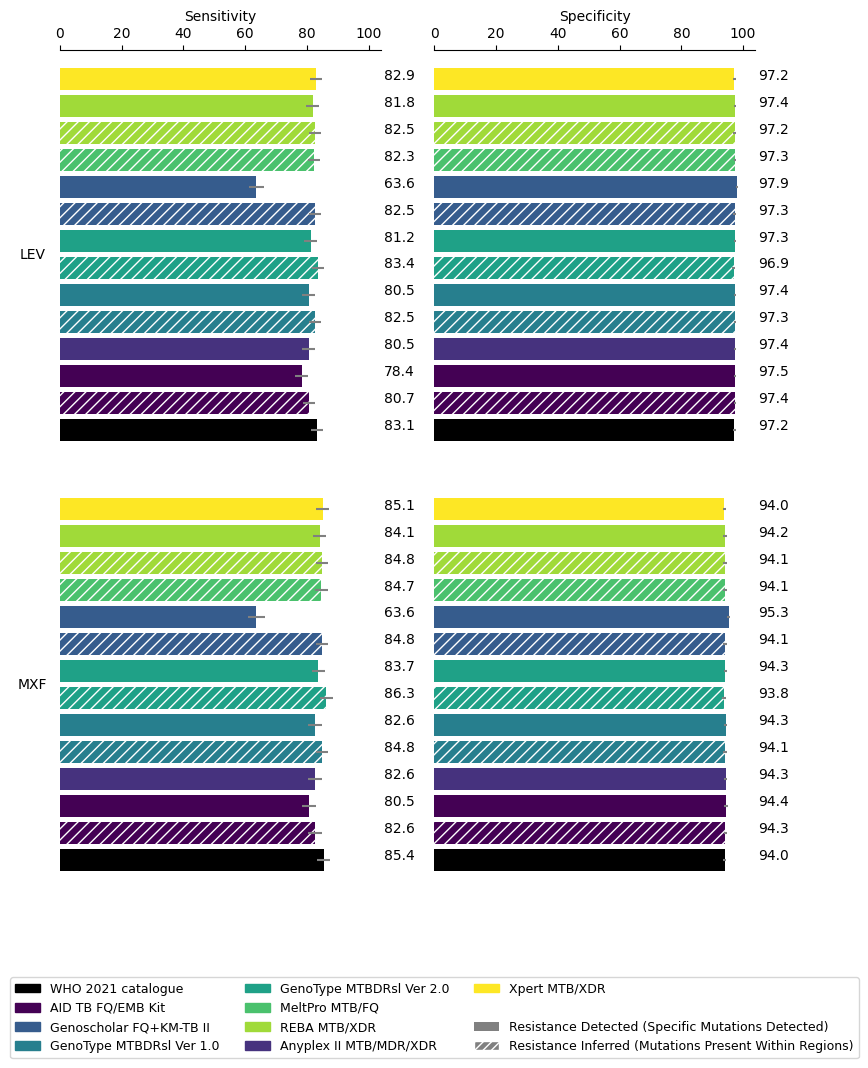

In [11]:
#make graph of results
pattern_dict={'region':'///','mut':'', 'cat':''} 
drugs=['LEV','MXF']
kws=[]
for i in drugs:
    kws.append(len(results_df.loc[(results_df.Drug==i)&(results_df.Sensitivity>0)]))

fig, axs = plt.subplots(len(drugs),2, 
                        gridspec_kw={'height_ratios': kws}, figsize=(8,sum(kws)/3), sharex=True)



for i in range(len(drugs)):
    label=[]
    pattern=[]
    graph_df = results_df.loc[(results_df.Drug==drugs[i])&(results_df.Sensitivity>0)]
    graph_df=sort_values(graph_df, ['Name'], ascending=True, fixed=graph_df.loc[graph_df.Mut_or_Reg=='cat'].index)
    name=graph_df.Name.to_list()
    print(name)
    mut_or_reg=graph_df.Mut_or_Reg.to_list()
    for iii in range(len(name)):
        label.append(graph_df.Name.to_list()[iii]+' '+graph_df.Mut_or_Reg.to_list()[iii])
   
    x_pos = [j for j, _ in enumerate(name)]
    sens=graph_df.Sensitivity*100
    spec=graph_df.Specificity*100
    sens_ci=(graph_df.Sensitivity-graph_df.sens_LB)*100
    spec_ci=(graph_df.Specificity-graph_df.spec_LB)*100
    colors=[]
    pattern=[]
    plt.rcParams['hatch.color'] = 'w' 
    for iii in range(len(name)):
        colors.append(colors_dict[name[iii]])
        pattern.append(pattern_dict[mut_or_reg[iii]])

    axs[ i, 0].barh(x_pos, sens, color=colors, hatch=pattern, xerr=sens_ci, ecolor='gray',zorder=1)
    axs[ i, 1].barh(x_pos, spec, color=colors, hatch=pattern, xerr=spec_ci, ecolor='gray',zorder=1)

    
    
    
    if i==0:
        axs[i,0].xaxis.set_ticks_position('top')
        axs[i,0].axes.set_xlabel('Sensitivity')
        axs[i,0].xaxis.set_label_position('top')
        axs[i,1].xaxis.set_ticks_position('top')
        axs[i,1].axes.set_xlabel('Specificity')
        axs[i,1].xaxis.set_label_position('top')
        
        for ii in ['left','right','bottom']:
            axs[i,0].spines[ii].set_visible(False)
            axs[i,1].spines[ii].set_visible(False)
        axs[i,0].axes.set_xlim(0,104)
    
        
    else:
        axs[i,0].axes.get_xaxis().set_visible(False)
        axs[i,1].axes.get_xaxis().set_visible(False)
        for ii in ['left','right','top','bottom']:
            axs[i,0].spines[ii].set_visible(False)
            axs[i,1].spines[ii].set_visible(False)

    axs[i,1].axes.get_yaxis().set_visible(False)
    axs[i,0].axes.set_ylabel(drugs[i], rotation=0, va='center', labelpad=20)
    axs[i,0].axes.set_yticks([])
    
    for index, value in enumerate(sens):
        axs[i,0].text(105, index, '{:0.1f}'.format(value))
        
    for index, value in enumerate(spec):
        axs[i,1].text(105, index, '{:0.1f}'.format(value))
    
    plt.tight_layout()
    
import matplotlib.patches as mpatches
patches = [] 
for i in results_df.loc[(results_df.Drug.isin(drugs))].Name.unique():
    patches.append(mpatches.Patch(color=colors_dict[i], label=i))

patches.append(mpatches.Patch( facecolor='w',label=''))
patches.append(mpatches.Patch( facecolor='grey',label='Resistance Detected (Specific Mutations Detected)'))
patches.append(mpatches.Patch( facecolor='grey',edgecolor='w',hatch='////',label='Resistance Inferred (Mutations Present Within Regions)'))
#patches=patches.append(h_patch)
plt.legend(handles=patches, prop={'size': 9}, loc="upper center", bbox_to_anchor=(0, -0.2), ncol=3) 
 
#fig.legend(patches, labels, loc='upper right')
        
plt.savefig('test_sens&spec_v3_sl.png', dpi=300, transparent=True, bbox_inches='tight')